# Predicting bicycle-traffic in Zurich

The city of Zurich is maintaining several measurement stations to detect numbers of pedestrians and bicyclists. Pedestrians are measured with infrared sensors while bicyclists are detected with induction loops in the ground.

>*Vehicle detection loops, called inductive-loop traffic detectors, can detect vehicles passing or arriving at a certain point, for instance approaching a traffic light or in motorway traffic. An insulated, electrically conducting loop is installed in the pavement.*

(Wikipedia)

![alt text](https://s1.srf.ch/var/storage/images/auftritte/sendungsauftritte/kassensturz_espresso/audios/node_10571901/118733041-2-ger-DE/bild_s8.jpg "inductive loop")

In the following I will visualize the collected data for the last 7 years in 21 different places throughout the city. I gathered and organized the data in a database. I'll try to show some different aspects of it and how it changed over time. Finally I will try to fit a regression model to the data to approximately predict traffic flows for a given day.

In [1102]:
%reload_ext sql

In [1127]:
%sql postgresql://chrble@/chrble

u'Connected: chrble@chrble'

In [1104]:
%sql SELECT * FROM traffic.measurements LIMIT 5;

5 rows affected.


objectid,date,velo_in,velo_out,ped_in,ped_out,place
3219797,2015-06-22 10:00:00,2,5,0,0,ECO09113500
3219798,2015-06-22 10:15:00,6,6,0,0,ECO09113500
3219799,2015-06-22 10:30:00,4,3,0,0,ECO09113500
3219800,2015-06-22 10:45:00,5,1,0,0,ECO09113500
3219801,2015-06-22 11:00:00,3,3,0,0,ECO09113500


In [1131]:
%sql SELECT * FROM traffic.places LIMIT 5;

5 rows affected.


abbr,descr,up_to,place_id,direction_in,direction_out,until,east,north,east_wgs,north_wgs
VZS_BINZ,Binzmühlestrasse,None,ECO09113500,Oerlikon,Glaubtenstrasse,2010-11-30 00:00:00,2681856.93,1251990.855,8.52328638868,47.4136413252
VZS_BUCH,Bucheggplatz,None,ECO09113505,Hofwiesenstrasse,Höngg,2014-06-26 00:00:00,2682646.917,1250363.848,8.53345215128,47.3989104954
VZS_KLOW,Kloster-Fahr-Weg,None,Y0412032046,Stadtgrenze,Innenstadt,2010-06-25 00:00:00,2679027.936,1250673.865,8.48557195358,47.4021427627
VZS_HOFW,Hofwiesenstrasse,None,ECO09113507,Bucheggplatz,,2010-09-23 00:00:00,2682695.918,1250605.849,8.5341459376,47.4010807345
VZS_LIMB,Limmatquai Ri. Bellevue,None,Y2G14045586,Bellevue,---,2014-06-25 00:00:00,2683446.897,1247062.835,8.54343250773,47.3691225029


In [1106]:
%%sql

CREATE VIEW interesting_places AS SELECT s.place_id,s.count,s.years,p.descr,p.east_wgs,p.north_wgs FROM 
traffic.sensors as s 
INNER JOIN 
traffic.places as p 
ON (s.place_id=p.place_id) 
WHERE ARRAY[2013,2014,2015,2016] <@ s.years;

(psycopg2.ProgrammingError) relation "interesting_places" already exists
 [SQL: 'CREATE VIEW interesting_places AS SELECT s.place_id,s.count,s.years,p.descr,p.east_wgs,p.north_wgs FROM \ntraffic.sensors as s \nINNER JOIN \ntraffic.places as p \nON (s.place_id=p.place_id) \nWHERE ARRAY[2013,2014,2015,2016] <@ s.years;']


In [1107]:
interesting_places=%sql SELECT * FROM interesting_places;
velo_places=%sql SELECT DISTINCT p.place_id,p.descr FROM interesting_places as p INNER JOIN traffic.total_traffic as m ON (p.place_id=m.place) WHERE NOT m.velo_num = 0 ;

21 rows affected.
13 rows affected.


In [1108]:
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
import cv2,time,calendar,math
from datetime import date
import seaborn as sea
sea.set_style("whitegrid", {'axes.grid' : False})
from ipywidgets import *
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr
import matplotlib.cm as cm
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
matplotlib.rcParams.update({'font.size': 22})

In [1109]:
def get_nums(y):
    numbers =%sql SELECT * FROM interesting_places as p INNER JOIN traffic.total_traffic as m ON (p.place_id=m.place) WHERE m.year = $y ;
    return numbers

### Plotting a map of the measurement locations

21 rows affected.


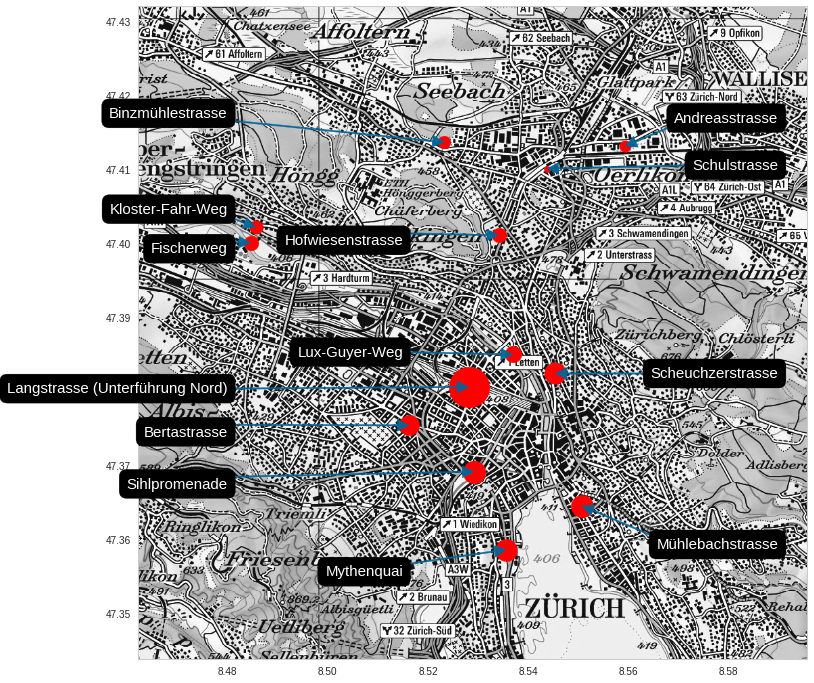

In [1110]:
img=cv2.imread("Zurich_map.png")
colors=cm.ScalarMappable(cmap="plasma").to_rgba(range(len(interesting_places)))
grey_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
orig_image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

@interact(year=Dropdown(options=range(2010,2017)[::-1], description='year',layout=Layout(width='10%',)),
         mot=RadioButtons(options=["bicyclists","pedestrians"],description="transport",layout=Layout(width="40%")))
def show_map(year,mot):
    start_time=time.time()
    fig,ax = plt.subplots(figsize=(12,12))
    plt.ylim(47.34392,47.43197) 
    plt.xlim(8.46202,8.59580)
    ax.imshow(grey_image, extent=[8.46202,8.59580,47.34392,47.43197],aspect="auto",cmap='gray')
    numbers=get_nums(year)
    #print "time1:",time.time()-start_time
    for i,p in enumerate(numbers):
        if mot=="bicyclists" and p[9]==0:
            continue
        if mot=="pedestrians" and p[8]==0:
            continue
        plt.scatter(x=[p[4]],y=[p[5]],s=(p[9]/1000.0 if mot=="bicyclists" else p[8]/1000.0),color="Red")
        if p[4]<8.54 and p[4]>8.53:
            lt=8.515
        elif p[4]<8.54:
            lt=8.48
        else:
            lt=8.59
        if p[3] in [u"Hofwiesenstrasse",u"Fischerweg",u"Schulstrasse",u"Weinbergfussweg",u"Mühlebachstrasse",u"Militärbrücke"]:
            yt=p[5]+((p[5]-47.39)/8.0) -0.003
        else:
            yt=p[5]+((p[5]-47.39)/8.0)
        plt.annotate(
            p[3],
            xy=(p[4], p[5]), xytext=(lt, yt), fontsize=15, color="white",
            textcoords='data', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='black',alpha=1,),
            arrowprops=dict( connectionstyle='arc3,rad=0',color=(0.0, 0.4, 0.6,0.95),width=1.5))
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0,fontsize=13)
    plt.show()
    #print "time4:",time.time()-start_time

### Measurement locations and traffic volumes 

21 rows affected.


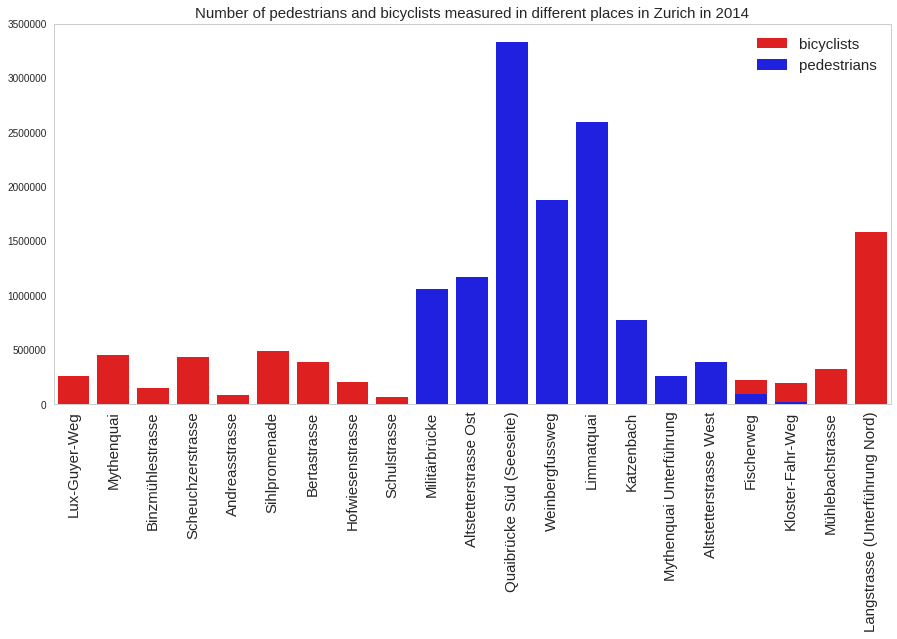

In [1111]:
@interact(year=Dropdown(options=["2014", "2015", "2016"], description='year'))
def year_measures(year):
    numbers =%sql SELECT * FROM interesting_places as p INNER JOIN traffic.total_traffic as m ON (p.place_id=m.place) WHERE m.year = $year ;
    #sea.xticks([p[0] for p in interesting_places])
    plt.figure(figsize=(15,7))

    plt.title("Number of pedestrians and bicyclists measured in different places in Zurich in "+year,fontsize=15)
    plt.xticks(rotation="vertical",fontsize=15)
    sea.barplot([p[3] for p in numbers],[p[8]+p[9] for p in numbers],color="red",label="bicyclists")
    sea.barplot([p[3] for p in numbers],[p[8] for p in numbers],color="blue",label="pedestrians")
    plt.legend(fontsize=15)
    plt.show()

### Finding a quadratic fit to monthly data

In [1112]:
# Fit a line to some data using least squares minimization

from scipy.optimize import leastsq

def yfit_linear(x, a):  
    return a[0] + a[1] * x
    
def yfit_quadratic(x,a):
    return a[0] + a[1] * x + a[2] * x**2 
    
def funcdiff_linear(a, xdata, ydata):   
    return yfit_linear(xdata, a) - ydata
    
def funcdiff_quadratic(a, xdata, ydata):   
    return yfit_quadratic(xdata, a) - ydata
 
def fit_regression(X,y):
    print "pearson coefficient: ",pearsonr(X[:,1],y)
    a_init = np.array([0.,0.,0.])
    result = leastsq(funcdiff_quadratic, a_init, args=(X[:,1],y))
    yfit = yfit_quadratic(np.array(range(1,13)),result[0])
    return yfit
    

60 rows affected.
pearson coefficient:  (0.30140574607094661, 0.019269475931985369)


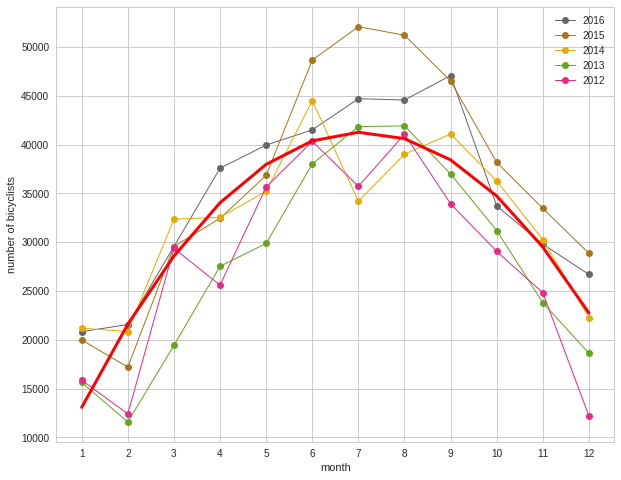

In [1130]:
colors=cm.ScalarMappable(cmap="Dark2").to_rgba(range(2009,2017))
colors={y:c for y,c in zip(range(2009,2017),colors)}
@interact(place=Dropdown(options={p[1]:p[0] for p in velo_places}),
          years=SelectMultiple(options=range(2009,2017)[::-1], value=[2013,2014,2015,2016]))
def plot_regression(place,years):
    years_q=list(years)
    fig,ax=plt.subplots()
    
    data=%sql SELECT * FROM traffic.monthly_traffic WHERE place='$place' AND year::int = ANY (ARRAY$years_q);
    X,y = np.array([d[:2] for d in data]),np.array([d[3] for d in data])
    for year in years:
        ax.plot([m for ye,m in list(X) if int(ye)==year],[t for (ye,m),t in zip(list(X),list(y)) if int(ye)==year],
                 color=colors[int(year)],label=int(year),marker='o',lw=1.0)
    #plt.plot(X[:,1],y,c=colors)
    yf=fit_regression(X,y)
    plt.ylabel("number of bicyclists")
    plt.xlabel("month")
    plt.grid(True)
    ax.set_xticks(range(13))
    ax.plot(range(1,13),yf,color="red",lw=3.0)
    ax.legend()
    plt.show()

### Plotting daily bicycle traffic numbers

1094 rows affected.


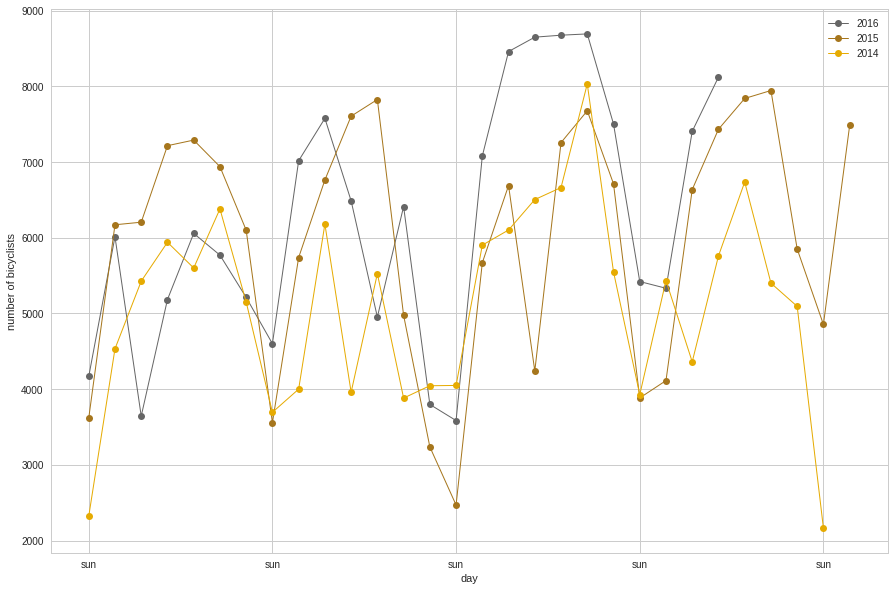

In [1114]:
@interact(place=Dropdown(options={p[1]:p[0] for p in velo_places}),
         years=SelectMultiple(options=range(2009,2017)[::-1], value=[2016]),
         months=SelectMultiple(options=range(1,13), value=list(range(1,13))),
         align_weekdays=ToggleButton(value=False,icon="check",layout=Layout(margin="0 0 0 120px")))
def plot_stuff(place,years,months,align_weekdays):
    years_q=list(years)
    fig,ax=plt.subplots(figsize=(15,10))
    
    data=%sql SELECT year,month,day,SUM(velo_num)  FROM traffic.hourly_traffic WHERE place='$place' AND year::int = ANY (ARRAY$years_q) GROUP BY day,month,year ORDER BY month,day;
    X,y = np.array([d[:3] for d in data]),np.array([float(d[3]) for d in data])
    for year in years:
        x_inp=filter(lambda (ye,m,d): int(ye)==year and int(m) in months, list(X))
        y_inp=[t for (ye,m,d),t in zip(list(X),list(y)) if int(ye)==year and int(m) in months]
        
        week_start=0
        if align_weekdays:
            x_ticks=[i for i,(ye,m,d) in enumerate(filter(lambda (ye,m,d): int(ye)==year and int(m) in months, list(X))) if date(int(ye),int(m),int(d)).weekday()==6]
            ax.set_xticks([x-x_ticks[0] for x in x_ticks])
            ax.set_xticklabels(["sun" for i in [x-x_ticks[0] for x in x_ticks]])
            x_inp=x_inp[x_ticks[0]:]
            y_inp=y_inp[x_ticks[0]:]
        ax.plot([i for i,o in enumerate(x_inp)],y_inp, color=colors[int(year)],label=(int(year)),marker='o',lw=1.0)
    #plt.plot(X[:,1],y,c=colors)
    plt.ylabel("number of bicyclists")
    plt.xlabel("day")
    plt.grid(True)
        
    #ax.plot(range(1,13),yf,color="red")
    ax.legend()
    plt.show()

In [1115]:
def get_weather(place):
    dtw=%sql SELECT d.day,d.month,d.year,d.velo_num,w.precip,w.airtemp,w.windspeed,EXTRACT(dow FROM w.date) as dow,EXTRACT(dow FROM w.date)^2 as square_dow FROM (SELECT day,month,year, SUM(velo_num) as velo_num FROM traffic.hourly_traffic WHERE place='$place' GROUP BY day,month,year,place) as d JOIN traffic.weather as w ON(to_date(d.month::int8::varchar||' '||d.day::int8::varchar||' '||d.year::int8::varchar,'MM DD YYYY')=w.date);
    return dtw

### Correlation between day of the week and bicycle traffic

2241 rows affected.


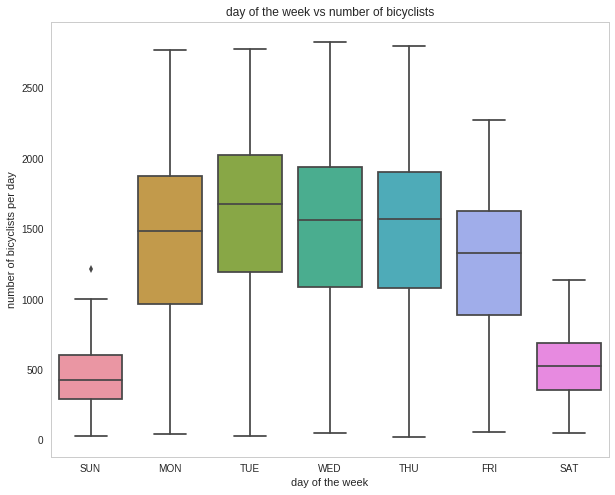

In [1116]:
@interact(place=Dropdown(options={p[1]:p[0] for p in velo_places}))
def plot_days_of_week(place):
    dtw = get_weather(place)
    X_dow = [float(d[7]) for d in dtw]
    y_dow = [float(d[3]) for d in dtw]
    plt.title("day of the week vs number of bicyclists")
    plt.xlabel("day of the week")
    plt.ylabel("number of bicyclists per day")

    ax=sea.boxplot(X_dow,y_dow)
    ax.set_xticklabels(["SUN","MON","TUE","WED","THU","FRI","SAT"])
    plt.show()

### Correlations between weather and bicycle traffic

In [1117]:
%sql select * from traffic.weather LIMIT 5;

5 rows affected.


date,airtemp,watertemp,windbo,windspeed,windstr,winddir,windc,press,precip,ice,rad,hum,pegel
2010-01-01,3.9,5.8,8.1,0.2,0.0,227.7,3.8,947.0,5.7,2.0,19.5,87.8,405.9
2010-01-02,-1.3,5.6,10.7,0.7,1.0,271.7,-2.0,968.0,0.2,-7.0,53.0,65.8,405.9
2010-01-03,-3.5,5.2,3.5,0.0,0.0,192.3,-3.5,972.4,0.0,-8.5,79.9,69.5,405.8
2010-01-04,-4.9,4.9,2.9,0.0,0.0,280.5,-4.9,966.0,0.0,-8.0,67.6,79.2,405.8
2010-01-05,-4.3,4.9,3.0,0.0,0.0,190.7,-4.3,957.4,0.6,-6.6,23.0,84.2,405.8


2298 rows affected.
pearson coefficient:  (-0.094702414164706053, 5.4274939018693784e-06)


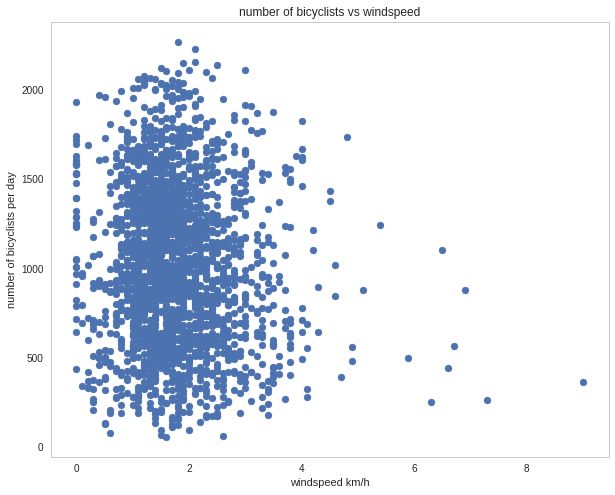

In [1118]:
#print np.median(X)
@interact(place=Dropdown(options={p[1]:p[0] for p in velo_places}),
         param=Dropdown(options=["Precipitation","Temperature","Windspeed"]))
def weather_show(place,param):
    dtw = get_weather(place)
    y = [float(d[3]) for d in dtw]
    X1 = [float(d[5]) for d in dtw]
    X2 = [float(d[4]) for d in dtw]
    X3 = [float(d[6]) for d in dtw]
    X4 = [float(d[7]) for d in dtw]
    if param=="Precipitation":
        print "pearson coefficient: ",pearsonr(X2,y)
        plt.title("number of bicyclists vs daily precipitation")
        plt.ylabel("number of bicyclists per day")
        plt.xlabel("milimeters of precipitation")
        plt.scatter(X2,y)
    elif param=="Temperature":
        print "pearson coefficient: ",pearsonr(X1,y)
        plt.title("number of bicyclists vs temperature")
        plt.ylabel("number of bicyclists per day")
        plt.xlabel("temperature in Celcius")
        plt.scatter(X1,y)
    elif param== "Windspeed":
        print "pearson coefficient: ",pearsonr(X3,y)
        plt.title("number of bicyclists vs windspeed")
        plt.ylabel("number of bicyclists per day")
        plt.xlabel("windspeed km/h")
        plt.scatter(X3,y)
        
    
    #sea.boxplot(X,y)
    plt.show()

### Multivariable Regression

In [1119]:
def cross_valid(k,data):
    splits=[]
    for i in range(k):
        start=int((1/float(k))*len(data)*i)
        stop=int((1/float(k))*len(data)*(i+1))
        test = data[start:stop]
        train = data[:start]+data[stop:]
        splits.append((train,test))
    return splits

2500 rows affected.
Coefficient of determination R^2:  0.780614059582


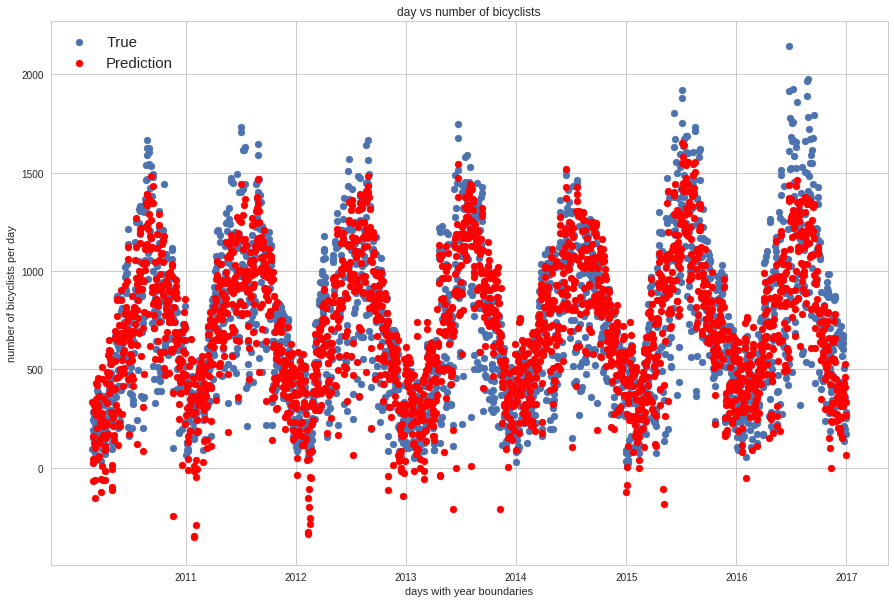

In [1126]:
@interact(place=Dropdown(options={p[1]:p[0] for p in velo_places}),predict=Checkbox(value=False),
         features=SelectMultiple(options={"month":1,"year":2,"precip":4,"temp":5,"wind":6,"dow":7,"dow^2":8},value=[1,2,4,5,6,7,8]))
def mult_var_lr(place,predict,features):
    dtw = get_weather(place)
    X = np.array([[d[i] for i in features] for d in dtw])
    y = np.array([float(d[3]) for d in dtw])
    fig,ax=plt.subplots(figsize=(15,10))
    ax.scatter(range(X.shape[0]),y,label="True")
    if predict:
        prediction=[]
        scores=[]
        for train,test in cross_valid(5,[([d[i] for i in features],d[3]) for d in dtw]):
            lr=LinearRegression()
            lr.fit([feats for feats,targ in train],[targ for feats,targ in train])
            scores.append(lr.score([feats for feats,targ in test],[targ for feats,targ in test]))
            prediction+=list(lr.predict([feats for feats,targ in test]))
        ax.scatter(range(len(prediction)),prediction,label="Prediction",color="red")
        print "Coefficient of determination R^2: ",np.mean(scores)
    x_ticks = range(len(dtw),len(dtw)%365-1,-365)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(range(2017,2017-len(x_ticks),-1))
    plt.title("day vs number of bicyclists")
    plt.xlabel("days with year boundaries")
    plt.ylabel("number of bicyclists per day")
    plt.grid(True)
    plt.legend(fontsize=15)
    plt.show()

### How many bicyclists will there be in 10 years from now at Langstrasse?

In [1135]:
dtw = get_weather("Y2G12102807")
features=[1,2,4,5,6,7]
X,y = (np.array([[d[i] for i in features] for d in dtw]),np.array([float(d[3]) for d in dtw]))
lr=LinearRegression().fit(X,y)
lr.predict([[5,2027,0,25,1,6]])

1282 rows affected.


array([ 9929.30777696])

### Appendix